Importing Libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from datetime import datetime
import pandas as pd
from skimage.feature import local_binary_pattern
import cv2
import numpy as np


In [ ]:
url_dict ={
    "lagos fashion week": ["https://lagosfashionweek.ng/seasons/lagosfw-2025/emmy-kasbit"]
    }

In [ ]:
driver = webdriver.Chrome()

for web_page, urls in url_dict.items():
    folder = os.path.join('kasbit_images', web_page)
    if os.path.exists(folder):
        continue
    os.makedirs(folder, exist_ok=True)

    for url in urls:
        driver.get(url)
        time.sleep(15)

        elements = driver.find_elements(By.TAG_NAME, 'img')
        print(f"Found {len(elements)} image elements.")

        count = 0
        for index, img in enumerate(elements):
            src = img.get_attribute('src')
            if src and src.startswith("http"):
                try:
                    img_data = requests.get(src).content
                    filename = f"{'kasbit'}_{web_page}_{index+1}.jpg"
                    path = os.path.join(folder, filename)
                    with open((path), 'wb') as f:
                        f.write(img_data)
                except Exception as e:
                    print(f"Error downloading image {src}: {e}")
                    continue
        

driver.quit()
print("All Images from all websites downloaded.")

Found 42 image elements.
All Images from all websites downloaded.


In [ ]:
dataset_dict = {"kasbit_images": ["lagos fashion week"]}

processed_pics = {}

for kasbit, folders in dataset_dict.items():
    kasbit_img = []

    for folder in folders:
        folder_dir = os.path.join('kasbit_images', folder)
        new_dir = os.path.join(folder_dir, "processed")
        os.makedirs(new_dir, exist_ok = True)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "processed" in img_path:
                continue

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224,224))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_norm = img / 255.0
                    kasbit_img.append(img_norm)
                    cv2.imwrite(os.path.join(new_dir, img_name), cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue
    processed_pics[kasbit] = np.array(kasbit_img)
    print(f"Processed {len(kasbit_img)} images for {kasbit}.\n")

print("All brands have been preprocessed!")

Processed 16 images for rendoll_images.

All brands have been preprocessed!


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

mini_CNN = VGG16(weights='imagenet', include_top=False, pooling='avg')

imgen = ImageDataGenerator(rescale=1./255)
gen = imgen.flow_from_directory('kasbit_images', target_size=(224,224), batch_size=32, class_mode=None, shuffle=False)

features = mini_CNN.predict(gen)

filenames = gen.filenames
np.save('kasbit_features.npy', features)
np.save('kasbit_files.npy', filenames)

Found 32 images belonging to 1 classes.


c:\Users\User\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\fw_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


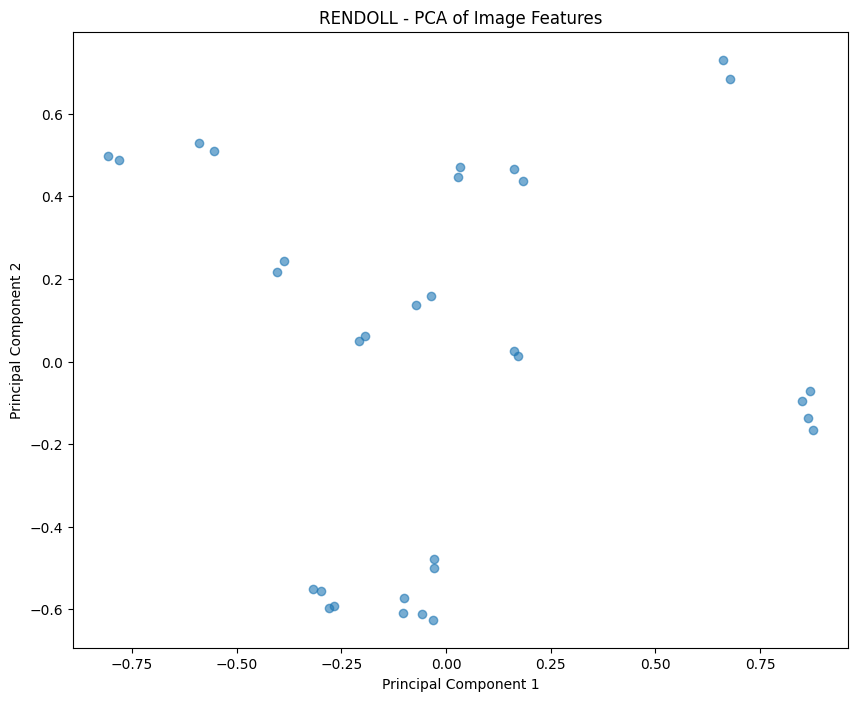

In [ ]:
X = np.load('kasbit_features.npy')
y = np.load('kasbit_files.npy')

pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(pca_results[:,0], pca_results[:,1], alpha=0.6)
plt.title('EMMY KASBIT - PCA of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [22]:
def extract_colors(image_path, n_colors=5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    # Reshape pixels for clustering
    pixels = img.reshape(-1, 3)
    
    # Use KMeans to find dominant colors
    from sklearn.cluster import KMeans
    from skimage.feature import local_binary_pattern
    
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    
    # Sort by frequency
    sorted_colors = colors[np.argsort(-counts)]
    return sorted_colors

def extract_sihlouette(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    X = mini_CNN.predict(img, verbose=0)
    return X.flatten()

def extract_texture(image_path, P=8, R=1):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    
    lbp = local_binary_pattern(img, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

In [ ]:
from rembg import remove
import io
silhouettes = []

folder = 'kasbit_images/lagos fashion week/processed'
for img_name in os.listdir(folder):
    img_path = os.path.join(folder, img_name)
    if img_name.lower().endswith(('.jpg','.jpeg', '.png')):
        with open(img_path, 'rb') as inp:
            output = remove(inp.read())
        silhouette_img = Image.open(io.BytesIO(output))
        silhouette_img.save(os.path.join(folder, f"silhouette_{img_name}"))
        img = cv2.imread(os.path.join(folder, f"silhouette_{img_name}"))
        grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(grayscale)
        cv2.drawContours(mask, contours, -1, 255, -1)
        silhouette = np.zeros_like(img)
        silhouette[mask == 255] = (0,0,0)
        plt.imshow(silhouette)
        plt.axis('off')
        plt.show()

ModuleNotFoundError: No module named 'onnxruntime'

In [ ]:
brand_colors = []
silhouettes = []
textures = []

folder = 'kasbit_images/lagos fashion week/processed'
for img_name in os.listdir(folder):
    if img_name.endswith(('.jpg','.png')):
        img_path = os.path.join(folder, img_name)
        colors = extract_colors(img_path, n_colors=3)
        brand_colors.extend(colors)

        silhouettes.append(extract_sihlouette(img_path))
        textures.append(extract_texture(img_path))

# Convert to NumPy array
brand_colors = np.array(brand_colors)
silhouettes_features = np.array(silhouettes)
textures = np.array(textures)


In [24]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans

kmeans_all = KMeans(n_clusters=5)
kmeans_all.fit(brand_colors)
common_colors = kmeans_all.cluster_centers_.astype(int)

print("Most common colors for brand:", common_colors)


Most common colors for brand: [[ 60  62  67]
 [185 192 210]
 [206  52  69]
 [150 141  78]
 [147 145 148]]


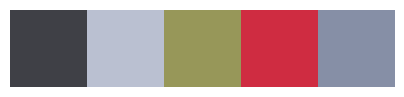

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_colors])
plt.axis('off')
plt.show()


In [ ]:
folder = 'kasbit_images/lagos fashion week/processed'
all_colors = []

for img_name in os.listdir(folder):
    if img_name.lower().endswith(('.jpg', '.png')):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pixels = img.reshape(-1, 3)
        color_fraction_list = extract_colors(img_path, n_colors=3)
        all_colors.append(pixels)

all_colors = np.vstack(all_colors)


overall_k = 5  # number of main colors for the collection
kmeans_all = KMeans(n_clusters=overall_k, random_state=42)
labels = kmeans_all.fit_predict(all_colors)  # weight by pixel fraction

dominant_colors = kmeans_all.cluster_centers_.astype(int)

# Calculate fraction of each dominant color
color_percentages = []

for i in range(overall_k):
    color_fraction = np.sum(labels == i) / len(labels)
    color_percentages.append(color_fraction * 100)

for color, perc in zip(dominant_colors, color_percentages):
    print(f"Color {color} appears in {perc:.2f}% of the collection")


Color [192 199 216] appears in 22.84% of the collection
Color [55 55 59] appears in 42.29% of the collection
Color [178  88  71] appears in 4.72% of the collection
Color [70 76 85] appears in 22.16% of the collection
Color [152 166 179] appears in 8.00% of the collection


In [30]:
# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans

kmeans_shape = KMeans(n_clusters=5, random_state=42)
#kmeans_shape.fit(silhouettes)
common_shapes = kmeans_shape.fit_predict(pca_results)

print("Most common silhouttes for brand:", common_shapes)


Most common silhouttes for brand: [2 2 1 1 1 3 3 1 1 4 0 0 2 2 2 3 2 2 1 1 1 3 3 1 1 4 0 0 2 2 2 3]


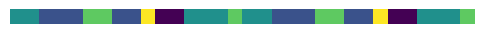

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_shapes])
plt.axis('off')
plt.show()